<a href="https://colab.research.google.com/github/soutrik71/pytorch_classics/blob/main/APTorch4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Next series of notebook s will be all about discussion on ( Not in Prder)
0. Basics of Embedding Model
1. Primary setup of Rnn architecture
2. Experiment with RNN on a few text based use cases
3. Primary setup of LSTM/GRU architecture
4. Experiment with LSTM/GRU on a few text based use cases
5. Embeddings and its different forms of experimentations
6. Experiment with pre-trained embedding models on a few text based use cases
7. Torchtext library and major functionalities

## BOOK1 -Word Embeddings Z2H

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
!pip install portalocker
!pip install torchview
!pip install torcheval
!pip install scikit-plot

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchtext
from torch.utils.data import DataLoader
from torchtext import data
from torchtext import datasets
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import re
from torch.utils.data import DataLoader
from torchtext.data.functional import to_map_style_dataset
from torchsummary import summary
from torchview import draw_graph
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from torcheval.metrics import MulticlassAccuracy,BinaryAccuracy
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix
import scikitplot as skplt

In [ ]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

In [ ]:
# Set manual seed since nn.Parameter are randomly initialzied
set_seed(42)
# Set device cuda for GPU if it's available otherwise run on the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
batch_size = 1024
epochs = 10
lr = 1e-3

Random seed set as 42
cpu


In [ ]:
def plot_loss_accuracy(train_loss, val_loss, train_acc, val_acc, labels, colors,
                       loss_legend_loc='upper center', acc_legend_loc='upper left', legend_font=5,
                       fig_size=(16, 10), sub_plot1=(1, 2, 1), sub_plot2=(1, 2, 2)):

    plt.rcParams["figure.figsize"] = fig_size
    plt.figure


    plt.subplot(sub_plot1[0], sub_plot1[1], sub_plot1[2])

    for i in range(len(train_loss)):
        x_train = range(len(train_loss[i]))
        x_val = range(len(val_loss[i]))

        min_train_loss = np.array(train_loss[i]).min()

        min_val_loss = np.array(val_loss[i]).min()

        plt.plot(x_train, train_loss[i], linestyle='-', color='tab:{}'.format(colors[i]),
                 label="TRAIN ({0:.4}): {1}".format(min_train_loss, labels[i]))
        plt.plot(x_val, val_loss[i], linestyle='--' , color='tab:{}'.format(colors[i]),
                 label="VALID ({0:.4}): {1}".format(min_val_loss, labels[i]))

    plt.xlabel('epoch no.')
    plt.ylabel('loss')
    plt.legend(loc=loss_legend_loc, prop={'size': legend_font})
    plt.title('Training and Validation Loss')

    plt.subplot(sub_plot2[0], sub_plot2[1], sub_plot2[2])

    for i in range(len(train_acc)):
        x_train = range(len(train_acc[i]))
        x_val = range(len(val_acc[i]))

        max_train_acc = np.array(train_acc[i]).max()

        max_val_acc = np.array(val_acc[i]).max()

        plt.plot(x_train, train_acc[i], linestyle='-', color='tab:{}'.format(colors[i]),
                 label="TRAIN ({0:.4}): {1}".format(max_train_acc, labels[i]))
        plt.plot(x_val, val_acc[i], linestyle='--' , color='tab:{}'.format(colors[i]),
                 label="VALID ({0:.4}): {1}".format(max_val_acc, labels[i]))

    plt.xlabel('epoch no.')
    plt.ylabel('accuracy')
    plt.legend(loc=acc_legend_loc, prop={'size': legend_font})
    plt.title('Training and Validation Accuracy')

    plt.show()


#### Dataset Preparation
In order to prepare the dataset, we have loaded the dataset, populated vocabulary with the words of text documents, and then created data loaders that will map words to their indexes according to vocabulary. Later on, when we give this list of word indexes (according to vocabulary) as input to the network, the embedding layer will map indexes to their respective embeddings.

In [ ]:
# get train and testset
train_dataset, test_dataset  = datasets.AG_NEWS()
train_dataset, test_dataset = to_map_style_dataset(train_dataset), to_map_style_dataset(test_dataset)

In [ ]:
# view data
train_iter = iter(datasets.AG_NEWS(split="train").shuffle()) # only training instances

In [ ]:
next(train_iter) # (label,text in the form of a tuples)

(1,
 'N. Korea calls Bush  quot;human trash quot; North Korea has hurled invective at US President George W. Bush for a second day, calling him a political idiot and human trash, and has said six-party talks on Pyongyang #39;s nuclear ambitions appear doomed.')

It has text documents for 4 different categories (["World", "Sports", "Business", "Sci/Tech"]) and label index starts form 0

#### Tokenize Text Data And Build Vocabulary
get_tokenizer() - a simple tokenizer that separates words from the sentence. It takes text as input and returns a list of tokens/words as output.
build_vocab_from_iterator() -generates a vocabulary mapping words to their indexes by iterating over datasets and their text documents, tokenizing them with a custom tokenizer function.

In [ ]:
def tokenizer(inp_str):
  """Returns list of words from the paragraph"""
  re.findall(r'\w+',inp_str)

# we wil use advanced tokenizer provided by torch
tokenizer = get_tokenizer("basic_english")
print(tokenizer("You can now install TorchText using pip!"))

['you', 'can', 'now', 'install', 'torchtext', 'using', 'pip', '!']


In [ ]:
def build_vocab_iter(datasets):
  """yields tokenized text """
  for dataset in datasets:
    for _, text in dataset:
      yield tokenizer(text)

vocab = build_vocab_from_iterator(build_vocab_iter([train_dataset, test_dataset]), specials=["<unk>"]) # build vocab from an iterator
vocab.set_default_index(vocab["<unk>"]) # anything unk will be have a default index

In [ ]:
sample = 'LA parking company lands contract renewal with ABIA Los Angeles-based Ampco System Parking has received a multi-year contract renewal with Austin-Bergstrom International Airport. '
tokenized_sample = tokenizer(sample)
print(tokenized_sample)
print(vocab(tokenized_sample))

['la', 'parking', 'company', 'lands', 'contract', 'renewal', 'with', 'abia', 'los', 'angeles-based', 'ampco', 'system', 'parking', 'has', 'received', 'a', 'multi-year', 'contract', 'renewal', 'with', 'austin-bergstrom', 'international', 'airport', '.']
[1747, 9585, 54, 4105, 424, 11934, 18, 60124, 580, 26155, 61237, 265, 9585, 28, 1192, 5, 9144, 424, 11934, 18, 62573, 139, 1174, 1]


The tokenizer is initialized using the "basic_english" tokenizer from torchtext.data.utils. dataset is loaded into training, validation, and testing iterators. The yield_tokens function tokenizes text iteratively, allowing efficient processing of large datasets by avoiding memory overload. The vocabulary is constructed from the iterator with a special token for unknown words, along with a default index for unknown words.

#### Dataloader
Train and test data loaders are created for data traversal during training. A helper function tokenizes and vectorizes text documents, limiting each document to a maximum of 50 words. It pads documents with fewer words and truncates those exceeding the limit. Target labels are mapped to [0,3] from [1,4], with a batch size of 1024, resulting in data of shape [1024,50] per batch with 1024 target labels for categories ["World", "Sports", "Business", "Sci/Tech"].
The data is passed through dataloader and ready for modelling

In [ ]:
def vectorize_batch(batch):
  """Vectorize the batch"""
  Y,X  = list(zip(*batch))
  X=[vocab(tokenizer(sample)) for sample in X]
  X = [sample+([0]* (50-len(sample))) if len(sample)<50 else sample[:50] for sample in X] ## Bringing all samples to 50 length ie standardization of length
  Y = [0 if y==0 else y-1 for y in Y] # converting label starting form 0
  return torch.tensor(X, dtype=torch.int64).to(device), torch.tensor(Y, dtype=torch.int64).to(device)

In [ ]:
target_classes = ["World", "Sports", "Business", "Sci/Tech"]

train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=vectorize_batch)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, collate_fn=vectorize_batch)

In [ ]:
for X, Y in train_loader:
    print(X.shape, Y.shape)
    break

torch.Size([1024, 50]) torch.Size([1024])


#### Basic Word Embedding Model

Neural network architecture: Embedding layer maps each word to 25 embeddings, followed by flattening. First linear layer: 1250 input units, 128 output units with ReLU activation. Second linear layer: 128 input units, 64 output units with ReLU activation. Third linear layer: 64 input units, 4 output units (number of target classes/labels).

In [ ]:
class BasicEmbeddingClassifier(nn.Module):
  """Basic Embedding Classifier"""
  def __init__(self, num_classes):
    super(BasicEmbeddingClassifier, self).__init__()

    self.embedding_layer = nn.Sequential(
        nn.Embedding(num_embeddings=98635, embedding_dim=25),
        nn.Flatten(),
        nn.Linear(1250, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, num_classes)
    )

  def forward(self, x):
    return self.embedding_layer(x)

In [ ]:
basic_embedder = BasicEmbeddingClassifier(4).to(device)
print(basic_embedder)

BasicEmbeddingClassifier(
  (embedding_layer): Sequential(
    (0): Embedding(98635, 25)
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): Linear(in_features=1250, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=4, bias=True)
  )
)


In [ ]:
# summary(basic_embedder, input_size=[(1024,50)], device='cpu')

In [ ]:
# # graphical representation of the model architecture
# model_graph = draw_graph(basic_embedder, input_size=(1,1024,50), expand_nested=True)
# model_graph.resize_graph(scale=10)
# model_graph.visual_graph

In [ ]:
def train_module(model:torch.nn.Module,
                 device:torch.device,
                 train_dataloader:torch.utils.data.DataLoader ,
                 optimizer:torch.optim.Optimizer,
                 criterion:torch.nn.Module,
                 metric,
                 train_losses:list,
                 train_metrics:list):

  # setting model to train mode
  model.train()
  pbar = tqdm(train_dataloader)

  # batch metrics
  train_loss = 0
  train_metric = 0
  processed_batch = 0

  for idx, (data,label) in enumerate(pbar):
    # setting up device
    data = data.to(device)
    label = label.to(device)

    # forward pass output
    preds = model(data)

    # calc loss
    loss = criterion(preds, label)
    train_loss += loss.item()
    # print(f"training loss for batch {idx} is {loss}")

    # backpropagation
    optimizer.zero_grad() # flush out  existing grads
    loss.backward() # back prop of weights wrt loss
    optimizer.step() # optimizer step -> minima

    # metric calc
    preds = torch.argmax(preds,dim=1)
    # print(f"preds:: {preds}")
    metric.update(preds,label)
    train_metric += metric.compute().detach().item()

    #updating batch count
    processed_batch += 1

    pbar.set_description(f"Avg Train Loss: {train_loss/processed_batch} Avg Train Metric: {train_metric/processed_batch}")

  # It's typically called after the epoch completes
  metric.reset()
  # updating epoch metrics
  train_losses.append(train_loss/processed_batch)
  train_metrics.append(train_metric/processed_batch)

  return train_losses, train_metrics


In [ ]:
def test_module(model:torch.nn.Module,
                device:torch.device,
                test_dataloader:torch.utils.data.DataLoader,
                criterion:torch.nn.Module,
                metric,
                test_losses,
                test_metrics):
  # setting model to eval mode
  model.eval()
  pbar = tqdm(test_dataloader)

  # batch metrics
  test_loss = 0
  test_metric = 0
  processed_batch = 0

  with torch.inference_mode():
    for idx, (data,label) in enumerate(pbar):
      data , label = data.to(device), label.to(device)
      # predictions
      preds = model(data)
      # print(preds.shape)
      # print(label.shape)

      #loss calc
      loss = criterion(preds, label)
      test_loss += loss.item()

      # metric calc
      preds = torch.argmax(preds,dim=1)
      metric.update(preds,label)
      test_metric += metric.compute().detach().item()

      #updating batch count
      processed_batch += 1

      pbar.set_description(f"Avg Test Loss: {test_loss/processed_batch} Avg Test Metric: {test_metric/processed_batch}")

    # It's typically called after the epoch completes
    metric.reset()
    # updating epoch metrics
    test_losses.append(test_loss/processed_batch)
    test_metrics.append(test_metric/processed_batch)

  return test_losses, test_metrics

In [ ]:
# driver setup
optimizer = optim.Adam(basic_embedder.parameters(), lr=lr, weight_decay=1e-3)
criterion = nn.CrossEntropyLoss()
metric = MulticlassAccuracy(device = device, num_classes=10)

In [ ]:
# Place holders----
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(0,epochs):
  print(f'Epoch {epoch}')
  train_losses, train_metrics = train_module(basic_embedder, device, train_loader, optimizer, criterion, metric, train_losses, train_metrics)
  test_losses , test_metrics = test_module(basic_embedder, device, test_loader, criterion, metric, test_losses, test_metrics)

Epoch 0


Avg Train Loss: 1.2798874610561435 Avg Train Metric: 0.3489892036985543: 100%|██████████| 118/118 [00:08<00:00, 13.52it/s]
Avg Test Loss: 1.2042866051197052 Avg Test Metric: 0.46928707510232925: 100%|██████████| 8/8 [00:00<00:00, 20.50it/s]


Epoch 1


Avg Train Loss: 1.1403992519540302 Avg Train Metric: 0.4877153864856494: 100%|██████████| 118/118 [00:09<00:00, 13.02it/s]
Avg Test Loss: 1.131031945347786 Avg Test Metric: 0.5133157670497894: 100%|██████████| 8/8 [00:00<00:00, 19.71it/s]


Epoch 2


Avg Train Loss: 1.0320543904425734 Avg Train Metric: 0.5521047297170607: 100%|██████████| 118/118 [00:08<00:00, 13.73it/s]
Avg Test Loss: 1.0640948563814163 Avg Test Metric: 0.5474351197481155: 100%|██████████| 8/8 [00:00<00:00, 19.68it/s]


Epoch 3


Avg Train Loss: 0.9162842479802794 Avg Train Metric: 0.6111194870229495: 100%|██████████| 118/118 [00:08<00:00, 13.46it/s]
Avg Test Loss: 1.0080533176660538 Avg Test Metric: 0.5819939002394676: 100%|██████████| 8/8 [00:00<00:00, 19.54it/s]


Epoch 4


Avg Train Loss: 0.8019839742426145 Avg Train Metric: 0.6672381864765943: 100%|██████████| 118/118 [00:09<00:00, 12.59it/s]
Avg Test Loss: 0.9577154517173767 Avg Test Metric: 0.6160972267389297: 100%|██████████| 8/8 [00:00<00:00, 17.34it/s]


Epoch 5


Avg Train Loss: 0.6962371877694534 Avg Train Metric: 0.7188442521176096: 100%|██████████| 118/118 [00:09<00:00, 12.83it/s]
Avg Test Loss: 0.9148283079266548 Avg Test Metric: 0.637284405529499: 100%|██████████| 8/8 [00:00<00:00, 18.49it/s]


Epoch 6


Avg Train Loss: 0.6020460805650485 Avg Train Metric: 0.7631769801600504: 100%|██████████| 118/118 [00:08<00:00, 13.54it/s]
Avg Test Loss: 0.897970400750637 Avg Test Metric: 0.6568443030118942: 100%|██████████| 8/8 [00:00<00:00, 20.46it/s]


Epoch 7


Avg Train Loss: 0.5214188674748954 Avg Train Metric: 0.8004788867497848: 100%|██████████| 118/118 [00:08<00:00, 13.62it/s]
Avg Test Loss: 0.8871237486600876 Avg Test Metric: 0.6724418252706528: 100%|██████████| 8/8 [00:00<00:00, 20.31it/s]


Epoch 8


Avg Train Loss: 0.4531741046930774 Avg Train Metric: 0.8290696255231308: 100%|██████████| 118/118 [00:08<00:00, 13.73it/s]
Avg Test Loss: 0.8781672343611717 Avg Test Metric: 0.6811115592718124: 100%|██████████| 8/8 [00:00<00:00, 19.94it/s]


Epoch 9


Avg Train Loss: 0.3992005813929994 Avg Train Metric: 0.8512050994371964: 100%|██████████| 118/118 [00:08<00:00, 13.75it/s]
Avg Test Loss: 0.8633472323417664 Avg Test Metric: 0.6927149295806885: 100%|██████████| 8/8 [00:00<00:00, 20.27it/s]


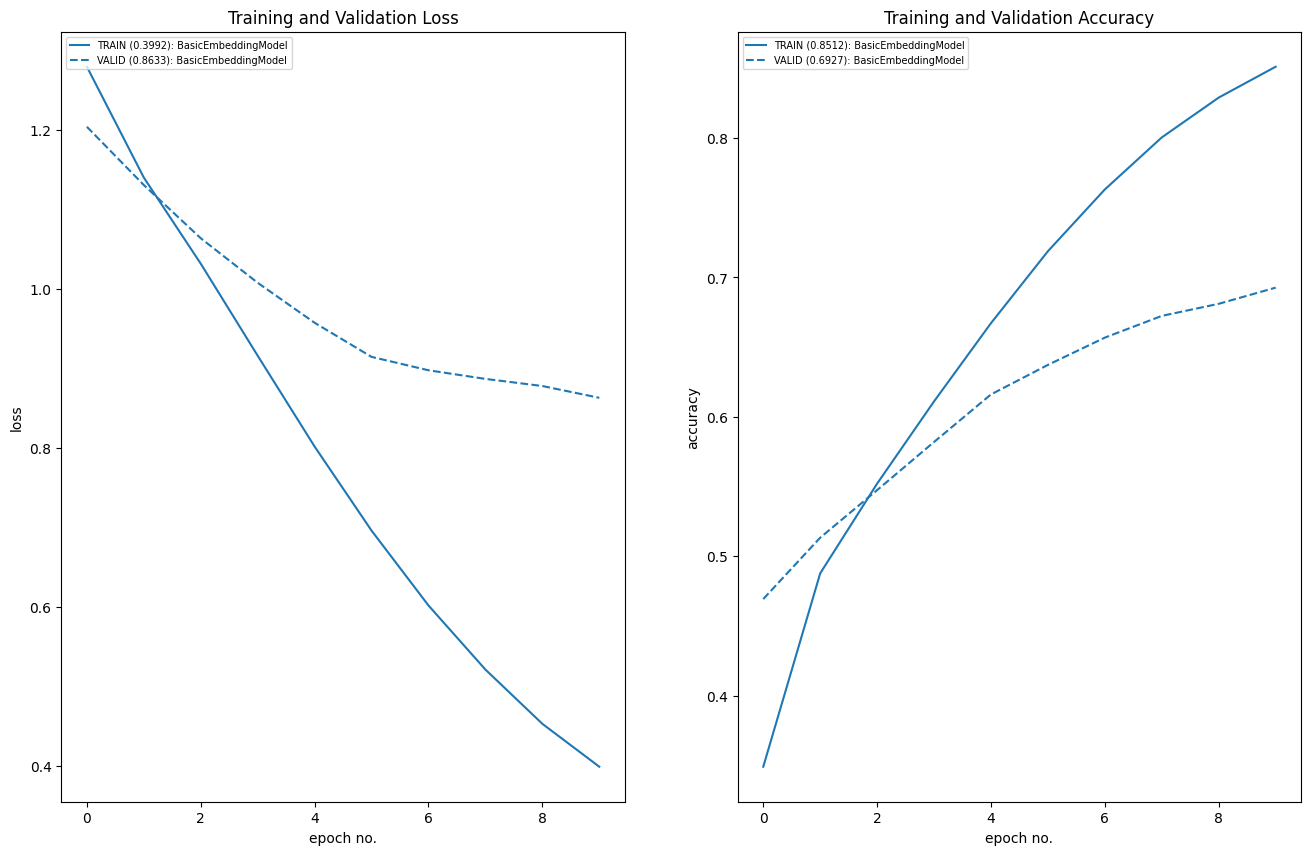

In [ ]:
plot_loss_accuracy(train_loss= [train_losses],
                   val_loss= [test_losses],
                   train_acc= [train_metrics],
                   val_acc= [test_metrics],
                   labels=['BasicEmbeddingModel'],
                   colors=['blue'],
                   loss_legend_loc='upper left',
                   acc_legend_loc='upper left',
                   legend_font=7)

Evaluate Network Performance

In [ ]:
def MakePredictions(model, loader):
    Y_shuffled, Y_preds = [], []
    for X, Y in loader:
        preds = model(X)
        Y_preds.append(preds)
        Y_shuffled.append(Y)

    Y_preds, Y_shuffled = torch.cat(Y_preds), torch.cat(Y_shuffled)
    return Y_shuffled.detach().numpy(), F.softmax(Y_preds, dim=-1).argmax(dim=-1).detach().numpy()


In [ ]:
Y_actual, Y_preds = MakePredictions(basic_embedder, test_loader)

In [ ]:
print(Y_actual.shape)
print(Y_preds.shape)

(7600,)
(7600,)


Precision vs Recall

Precision: Of all the instances predicted as positive, how many are actually positive?

Recall: Of all the actual positive instances, how many did the model correctly predict as positive?

precision focuses on the accuracy of positive predictions, while recall focuses on the model's ability to identify all positive instances

In [ ]:
print("Test Accuracy : {}".format(accuracy_score(Y_actual, Y_preds)))
print("\nClassification Report : ")
print(classification_report(Y_actual, Y_preds, target_names=target_classes))
print("\nConfusion Matrix : ")
print(confusion_matrix(Y_actual, Y_preds))

Test Accuracy : 0.6914473684210526

Classification Report : 
              precision    recall  f1-score   support

       World       0.68      0.72      0.70      1900
      Sports       0.74      0.85      0.79      1900
    Business       0.64      0.61      0.62      1900
    Sci/Tech       0.69      0.59      0.64      1900

    accuracy                           0.69      7600
   macro avg       0.69      0.69      0.69      7600
weighted avg       0.69      0.69      0.69      7600


Confusion Matrix : 
[[1360  232  196  112]
 [ 145 1610   82   63]
 [ 278  134 1159  329]
 [ 214  187  373 1126]]


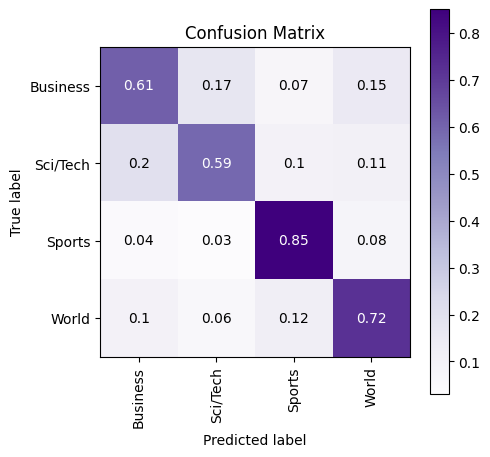

In [ ]:
skplt.metrics.plot_confusion_matrix([target_classes[i] for i in Y_actual], [target_classes[i] for i in Y_preds],
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Purples",
                                    hide_zeros=True,
                                    figsize=(5,5)
                                    );
plt.xticks(rotation=90);

#### Word Embeddings With More Embeddings

Increase the number of embeddings in the embedding layer from 25 to 50 ie double up and adding a dropout layer after embedding model

In [ ]:
class ScaledEmbeddingClassifier(nn.Module):
  """Basic Embedding Classifier"""
  def __init__(self, num_classes):
    super(ScaledEmbeddingClassifier, self).__init__()

    self.embedding_layer = nn.Sequential(
        nn.Embedding(num_embeddings=98635, embedding_dim=50),
        nn.Dropout(p=0.1),
        nn.Flatten(),
        nn.Linear(2500, 128), # 50 word len * 50 embeddings size
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, num_classes)
    )

  def forward(self, x):
    return self.embedding_layer(x)

In [ ]:
scaled_embedder = ScaledEmbeddingClassifier(num_classes=4)

In [ ]:
# driver setup
optimizer = optim.Adam(scaled_embedder.parameters(), lr=lr, weight_decay=1e-3)
criterion = nn.CrossEntropyLoss()
metric = MulticlassAccuracy(device = device, num_classes=10)

In [ ]:
# Place holders----
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(0,epochs):
  print(f'Epoch {epoch}')
  train_losses, train_metrics = train_module(scaled_embedder, device, train_loader, optimizer, criterion, metric, train_losses, train_metrics)
  test_losses , test_metrics = test_module(scaled_embedder, device, test_loader, criterion, metric, test_losses, test_metrics)

Epoch 0


Avg Train Loss: 1.2098389843762931 Avg Train Metric: 0.38229536555581173: 100%|██████████| 118/118 [00:11<00:00, 10.00it/s]
Avg Test Loss: 1.075465515255928 Avg Test Metric: 0.5536554828286171: 100%|██████████| 8/8 [00:00<00:00, 17.98it/s]


Epoch 1


Avg Train Loss: 1.0355713640229176 Avg Train Metric: 0.5496550060934939: 100%|██████████| 118/118 [00:11<00:00,  9.94it/s]
Avg Test Loss: 1.0045551359653473 Avg Test Metric: 0.5837227702140808: 100%|██████████| 8/8 [00:00<00:00, 18.31it/s]


Epoch 2


Avg Train Loss: 0.9416056901721631 Avg Train Metric: 0.5969223011348207: 100%|██████████| 118/118 [00:12<00:00,  9.74it/s]
Avg Test Loss: 0.9484574720263481 Avg Test Metric: 0.613062210381031: 100%|██████████| 8/8 [00:00<00:00, 19.26it/s]


Epoch 3


Avg Train Loss: 0.8517727116912098 Avg Train Metric: 0.6423690814082905: 100%|██████████| 118/118 [00:11<00:00, 10.08it/s]
Avg Test Loss: 0.9002816379070282 Avg Test Metric: 0.6337474286556244: 100%|██████████| 8/8 [00:00<00:00, 19.03it/s]


Epoch 4


Avg Train Loss: 0.762764181373483 Avg Train Metric: 0.6835707138150425: 100%|██████████| 118/118 [00:12<00:00,  9.81it/s]
Avg Test Loss: 0.861667275428772 Avg Test Metric: 0.6593284457921982: 100%|██████████| 8/8 [00:00<00:00, 19.13it/s]


Epoch 5


Avg Train Loss: 0.6755375647443836 Avg Train Metric: 0.7254894092931585: 100%|██████████| 118/118 [00:12<00:00,  9.74it/s]
Avg Test Loss: 0.8361992537975311 Avg Test Metric: 0.6701489165425301: 100%|██████████| 8/8 [00:00<00:00, 18.91it/s]


Epoch 6


Avg Train Loss: 0.5982512795066429 Avg Train Metric: 0.7581555525125083: 100%|██████████| 118/118 [00:11<00:00,  9.91it/s]
Avg Test Loss: 0.8184894099831581 Avg Test Metric: 0.6832259222865105: 100%|██████████| 8/8 [00:00<00:00, 18.78it/s]


Epoch 7


Avg Train Loss: 0.5332789599137792 Avg Train Metric: 0.7889542104834217: 100%|██████████| 118/118 [00:11<00:00, 10.05it/s]
Avg Test Loss: 0.795260414481163 Avg Test Metric: 0.6966497227549553: 100%|██████████| 8/8 [00:00<00:00, 18.88it/s]


Epoch 8


Avg Train Loss: 0.48304655466039303 Avg Train Metric: 0.8091452111632137: 100%|██████████| 118/118 [00:11<00:00,  9.98it/s]
Avg Test Loss: 0.7871235236525536 Avg Test Metric: 0.7030065059661865: 100%|██████████| 8/8 [00:00<00:00, 18.67it/s]


Epoch 9


Avg Train Loss: 0.44114434529664154 Avg Train Metric: 0.8280220001430835: 100%|██████████| 118/118 [00:12<00:00,  9.69it/s]
Avg Test Loss: 0.765187218785286 Avg Test Metric: 0.7212888300418854: 100%|██████████| 8/8 [00:00<00:00, 18.43it/s]


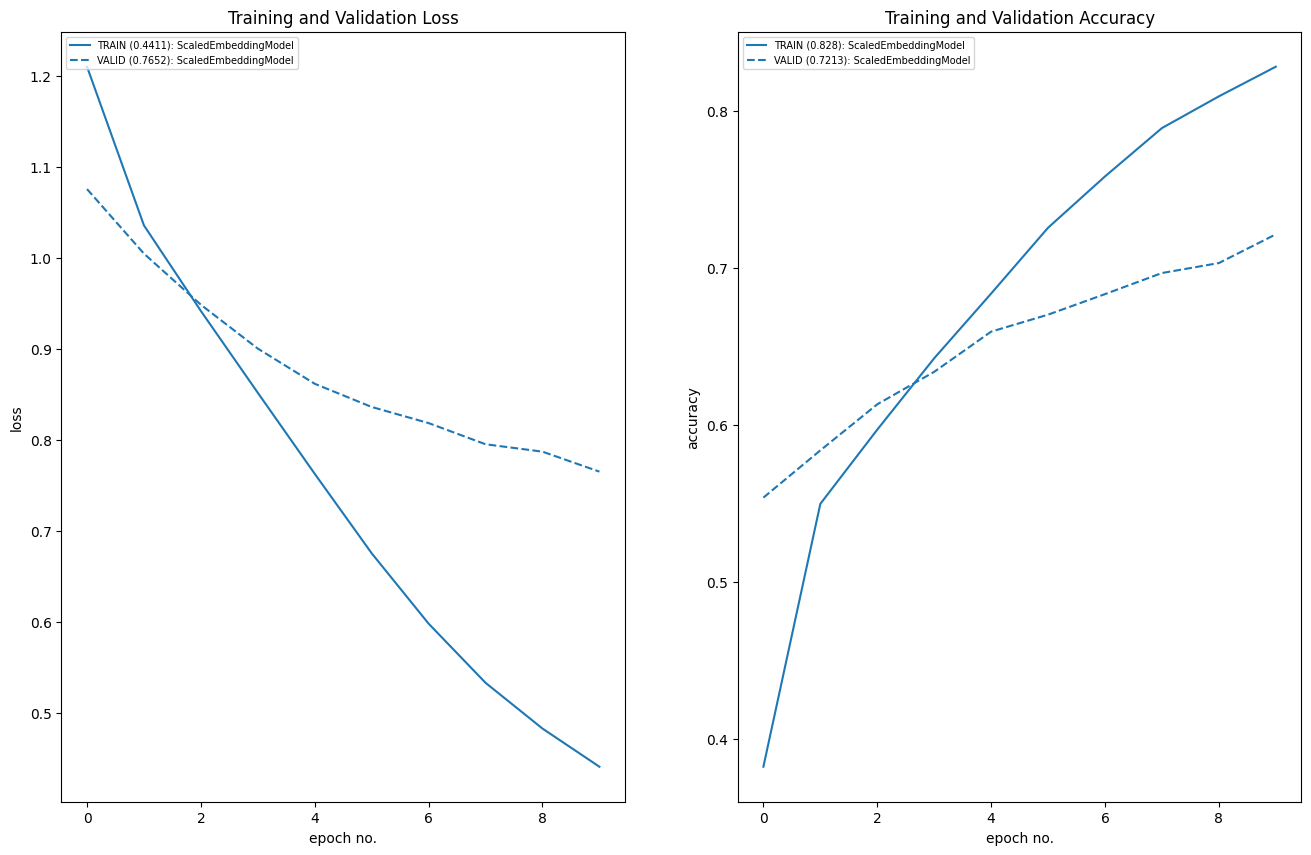

In [ ]:
plot_loss_accuracy(train_loss= [train_losses],
                   val_loss= [test_losses],
                   train_acc= [train_metrics],
                   val_acc= [test_metrics],
                   labels=['ScaledEmbeddingModel'],
                   colors=['blue'],
                   loss_legend_loc='upper left',
                   acc_legend_loc='upper left',
                   legend_font=7)

In [ ]:
Y_actual, Y_preds = MakePredictions(scaled_embedder, test_loader)

In [ ]:
print("Test Accuracy : {}".format(accuracy_score(Y_actual, Y_preds)))
print("\nClassification Report : ")
print(classification_report(Y_actual, Y_preds, target_names=target_classes))
print("\nConfusion Matrix : ")
print(confusion_matrix(Y_actual, Y_preds))

Test Accuracy : 0.7201315789473685

Classification Report : 
              precision    recall  f1-score   support

       World       0.79      0.67      0.72      1900
      Sports       0.69      0.90      0.78      1900
    Business       0.69      0.70      0.70      1900
    Sci/Tech       0.72      0.61      0.66      1900

    accuracy                           0.72      7600
   macro avg       0.72      0.72      0.72      7600
weighted avg       0.72      0.72      0.72      7600


Confusion Matrix : 
[[1268  309  196  127]
 [  78 1702   53   67]
 [ 118  182 1338  262]
 [ 137  256  342 1165]]


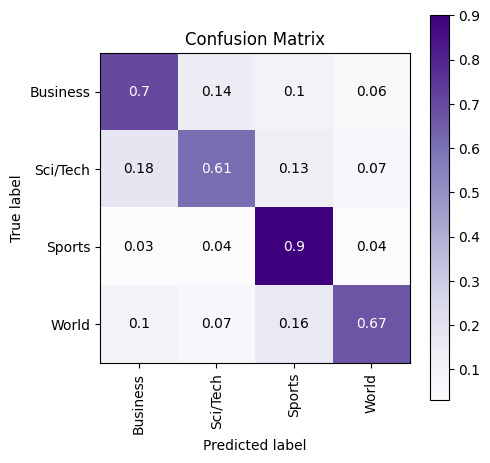

In [ ]:
skplt.metrics.plot_confusion_matrix([target_classes[i] for i in Y_actual], [target_classes[i] for i in Y_preds],
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Purples",
                                    hide_zeros=True,
                                    figsize=(5,5)
                                    );
plt.xticks(rotation=90);

#### Average Word Embeddings

In this approach, instead of keeping embeddings for all words/tokens of the text example laid next to each other, we calculate the average of embeddings of all tokens/words per text example ie average of each embedding vector for all word and using the scaled embedding model
nn.Embedding(num_embeddings=98635, embedding_dim=30)(X).mean(dim=1)

In [ ]:
class MeanWordEmbeddingsClassifier(nn.Module):
  """Average Embedding Model"""
  def __init__(self, num_classes):
    super(MeanWordEmbeddingsClassifier, self).__init__()

    self.embedder = nn.Embedding(num_embeddings=98635, embedding_dim=51)
    self.fc1 = nn.Linear(51, 128)
    self.fc2 = nn.Linear(128, 64)
    self.fc3 = nn.Linear(64, num_classes)

  def forward(self, x):
    x = self.embedder(x) # in->[1024,51] out->[1024,50,51]
    x = x.mean(dim=1) # in->[1024,50,51] out->[1024,51]
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    logits = self.fc3(x)
    return logits

In [ ]:
mean_scaled_embedder = MeanWordEmbeddingsClassifier(num_classes=4)

In [ ]:
# driver setup
optimizer = optim.Adam(mean_scaled_embedder.parameters(), lr=lr, weight_decay=1e-3)
criterion = nn.CrossEntropyLoss()
metric = MulticlassAccuracy(device = device, num_classes=10)

In [ ]:
# Place holders----
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(0,epochs):
  print(f'Epoch {epoch}')
  train_losses, train_metrics = train_module(mean_scaled_embedder, device, train_loader, optimizer, criterion, metric, train_losses, train_metrics)
  test_losses , test_metrics = test_module(mean_scaled_embedder, device, test_loader, criterion, metric, test_losses, test_metrics)

Epoch 0


Avg Train Loss: 1.3390122136827243 Avg Train Metric: 0.3150116624468464: 100%|██████████| 118/118 [00:09<00:00, 12.32it/s]
Avg Test Loss: 1.2527848929166794 Avg Test Metric: 0.4617859050631523: 100%|██████████| 8/8 [00:00<00:00, 21.97it/s]


Epoch 1


Avg Train Loss: 1.179126515226849 Avg Train Metric: 0.46973620936021965: 100%|██████████| 118/118 [00:10<00:00, 10.90it/s]
Avg Test Loss: 1.107058197259903 Avg Test Metric: 0.5280422493815422: 100%|██████████| 8/8 [00:00<00:00, 20.39it/s]


Epoch 2


Avg Train Loss: 1.0562336596391968 Avg Train Metric: 0.5426872746419098: 100%|██████████| 118/118 [00:10<00:00, 10.93it/s]
Avg Test Loss: 1.002643197774887 Avg Test Metric: 0.5843008011579514: 100%|██████████| 8/8 [00:00<00:00, 20.77it/s]


Epoch 3


Avg Train Loss: 0.9583732657513376 Avg Train Metric: 0.5934892503891961: 100%|██████████| 118/118 [00:10<00:00, 10.92it/s]
Avg Test Loss: 0.9182602614164352 Avg Test Metric: 0.6279141008853912: 100%|██████████| 8/8 [00:00<00:00, 19.85it/s]


Epoch 4


Avg Train Loss: 0.8765183091163635 Avg Train Metric: 0.6342333393581843: 100%|██████████| 118/118 [00:09<00:00, 12.22it/s]
Avg Test Loss: 0.846124604344368 Avg Test Metric: 0.659815825521946: 100%|██████████| 8/8 [00:00<00:00, 21.84it/s]


Epoch 5


Avg Train Loss: 0.8058464335182965 Avg Train Metric: 0.6684013231325958: 100%|██████████| 118/118 [00:10<00:00, 11.62it/s]
Avg Test Loss: 0.7816716879606247 Avg Test Metric: 0.6885612681508064: 100%|██████████| 8/8 [00:00<00:00, 21.59it/s]


Epoch 6


Avg Train Loss: 0.7432433341519308 Avg Train Metric: 0.6990759130251609: 100%|██████████| 118/118 [00:10<00:00, 11.42it/s]
Avg Test Loss: 0.7221105843782425 Avg Test Metric: 0.7183000817894936: 100%|██████████| 8/8 [00:00<00:00, 21.22it/s]


Epoch 7


Avg Train Loss: 0.6870877015388618 Avg Train Metric: 0.72605207612959: 100%|██████████| 118/118 [00:10<00:00, 11.23it/s]
Avg Test Loss: 0.6689276695251465 Avg Test Metric: 0.7365557998418808: 100%|██████████| 8/8 [00:00<00:00, 19.20it/s]


Epoch 8


Avg Train Loss: 0.6367290590779257 Avg Train Metric: 0.749130321256185: 100%|██████████| 118/118 [00:10<00:00, 11.46it/s]
Avg Test Loss: 0.6236073225736618 Avg Test Metric: 0.7564519420266151: 100%|██████████| 8/8 [00:00<00:00, 22.60it/s]


Epoch 9


Avg Train Loss: 0.5922626620632107 Avg Train Metric: 0.7685423074132305: 100%|██████████| 118/118 [00:09<00:00, 13.02it/s]
Avg Test Loss: 0.5833934620022774 Avg Test Metric: 0.7713453397154808: 100%|██████████| 8/8 [00:00<00:00, 21.80it/s]


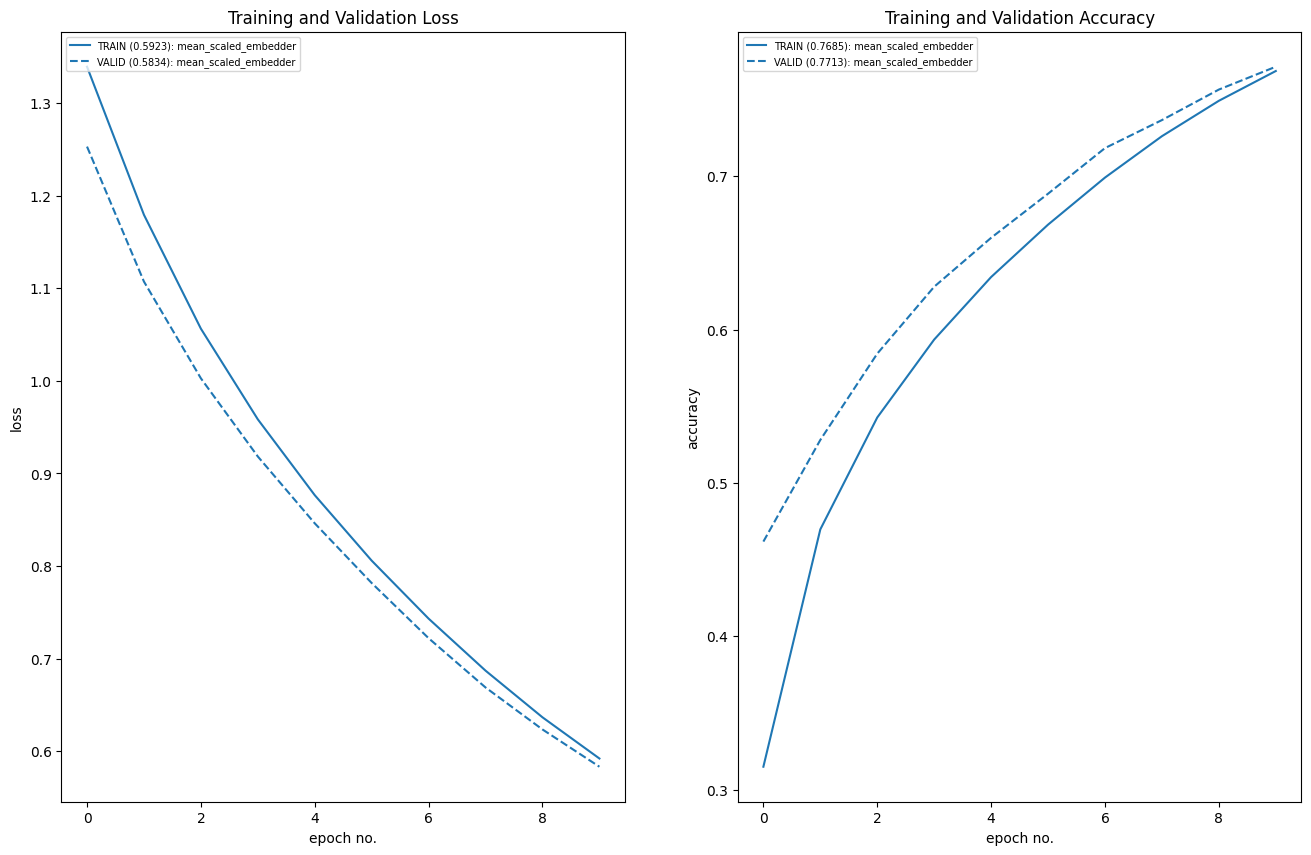

In [ ]:
plot_loss_accuracy(train_loss= [train_losses],
                   val_loss= [test_losses],
                   train_acc= [train_metrics],
                   val_acc= [test_metrics],
                   labels=['mean_scaled_embedder'],
                   colors=['blue'],
                   loss_legend_loc='upper left',
                   acc_legend_loc='upper left',
                   legend_font=7)

In [ ]:
Y_actual, Y_preds = MakePredictions(mean_scaled_embedder, test_loader)

In [ ]:
print("Test Accuracy : {}".format(accuracy_score(Y_actual, Y_preds)))
print("\nClassification Report : ")
print(classification_report(Y_actual, Y_preds, target_names=target_classes))
print("\nConfusion Matrix : ")
print(confusion_matrix(Y_actual, Y_preds))

Test Accuracy : 0.7796052631578947

Classification Report : 
              precision    recall  f1-score   support

       World       0.83      0.77      0.80      1900
      Sports       0.81      0.90      0.85      1900
    Business       0.72      0.76      0.74      1900
    Sci/Tech       0.75      0.69      0.72      1900

    accuracy                           0.78      7600
   macro avg       0.78      0.78      0.78      7600
weighted avg       0.78      0.78      0.78      7600


Confusion Matrix : 
[[1461  150  180  109]
 [  59 1706   63   72]
 [ 114   91 1446  249]
 [ 117  150  321 1312]]


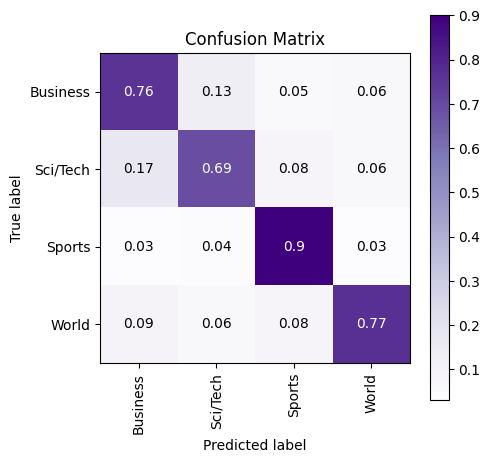

In [ ]:
skplt.metrics.plot_confusion_matrix([target_classes[i] for i in Y_actual], [target_classes[i] for i in Y_preds],
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Purples",
                                    hide_zeros=True,
                                    figsize=(5,5)
                                    );
plt.xticks(rotation=90);

#### Embedding Bag Approach

https://jamesmccaffrey.files.wordpress.com/2021/03/regular_embedding_vs_embedding_bag_diagram.jpg


Instead of each word being represented by an embedding vector, with an EmbeggingBag, each sentence is represented by an embedding vector. This simplification loses the sequential information so you use a simple neural network.

Compute sums or means of ‘bags’ of embeddings, without instantiating the intermediate embeddings.

For bags of constant length, no per_sample_weights, no indices equal to padding_idx, and with 2D inputs, this class

with mode="sum" is equivalent to Embedding followed by torch.sum(dim=1),

with mode="mean" is equivalent to Embedding followed by torch.mean(dim=1),

with mode="max" is equivalent to Embedding followed by torch.max(dim=1).

With an EmbeddingBag, you don’t need padding

The EmbeddingBag approach is often viable for situations where the input sequences are just one or two sentences and not for long sentences as we loose positionaland contextual information

In [185]:
class EmbeddingbagClassifier(nn.Module):
  """Embedding Bag Classifier"""
  def __init__(self, num_classes,mode='mean'):
    super(EmbeddingbagClassifier, self).__init__()

    self.embedding_layer = nn.Sequential(
        nn.EmbeddingBag(num_embeddings=98635, embedding_dim=50, mode=mode),
        nn.Linear(50, 128), # 50 average size for each batch
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, num_classes)
    )

  def forward(self, x):
    return self.embedding_layer(x)

In [186]:
bag_classifier = EmbeddingbagClassifier(num_classes=4, mode='mean')

In [187]:
# driver setup
optimizer = optim.Adam(bag_classifier.parameters(), lr=lr, weight_decay=1e-3)
criterion = nn.CrossEntropyLoss()
metric = MulticlassAccuracy(device = device, num_classes=10)

In [188]:
# Place holders----
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(0,epochs):
  print(f'Epoch {epoch}')
  train_losses, train_metrics = train_module(bag_classifier, device, train_loader, optimizer, criterion, metric, train_losses, train_metrics)
  test_losses , test_metrics = test_module(bag_classifier, device, test_loader, criterion, metric, test_losses, test_metrics)

Epoch 0


Avg Train Loss: 1.3417422751248893 Avg Train Metric: 0.3015472349726548: 100%|██████████| 118/118 [00:07<00:00, 14.93it/s]
Avg Test Loss: 1.2680874913930893 Avg Test Metric: 0.4440353251993656: 100%|██████████| 8/8 [00:00<00:00, 23.50it/s]


Epoch 1


Avg Train Loss: 1.1991068892559762 Avg Train Metric: 0.45857655395895747: 100%|██████████| 118/118 [00:08<00:00, 14.27it/s]
Avg Test Loss: 1.139053076505661 Avg Test Metric: 0.5164129137992859: 100%|██████████| 8/8 [00:00<00:00, 20.92it/s]


Epoch 2


Avg Train Loss: 1.0799190725310375 Avg Train Metric: 0.5316947112649174: 100%|██████████| 118/118 [00:08<00:00, 13.67it/s]
Avg Test Loss: 1.0251927971839905 Avg Test Metric: 0.5760946571826935: 100%|██████████| 8/8 [00:00<00:00, 23.69it/s]


Epoch 3


Avg Train Loss: 0.9726359662363084 Avg Train Metric: 0.5869533813605874: 100%|██████████| 118/118 [00:07<00:00, 15.96it/s]
Avg Test Loss: 0.9244842082262039 Avg Test Metric: 0.6254056468605995: 100%|██████████| 8/8 [00:00<00:00, 24.49it/s]


Epoch 4


Avg Train Loss: 0.880784576222048 Avg Train Metric: 0.6345140641018495: 100%|██████████| 118/118 [00:07<00:00, 15.46it/s]
Avg Test Loss: 0.8427576273679733 Avg Test Metric: 0.6621896028518677: 100%|██████████| 8/8 [00:00<00:00, 23.43it/s]


Epoch 5


Avg Train Loss: 0.8048567504195844 Avg Train Metric: 0.6727988123893738: 100%|██████████| 118/118 [00:07<00:00, 15.22it/s]
Avg Test Loss: 0.7754841148853302 Avg Test Metric: 0.6941389590501785: 100%|██████████| 8/8 [00:00<00:00, 23.14it/s]


Epoch 6


Avg Train Loss: 0.7406238827664974 Avg Train Metric: 0.7037221870179904: 100%|██████████| 118/118 [00:07<00:00, 15.44it/s]
Avg Test Loss: 0.7175309211015701 Avg Test Metric: 0.720654308795929: 100%|██████████| 8/8 [00:00<00:00, 22.40it/s]


Epoch 7


Avg Train Loss: 0.6846538256790679 Avg Train Metric: 0.7293258122468399: 100%|██████████| 118/118 [00:07<00:00, 15.08it/s]
Avg Test Loss: 0.6662026047706604 Avg Test Metric: 0.7426830306649208: 100%|██████████| 8/8 [00:00<00:00, 24.82it/s]


Epoch 8


Avg Train Loss: 0.6352073696710295 Avg Train Metric: 0.752712168430878: 100%|██████████| 118/118 [00:07<00:00, 14.86it/s]
Avg Test Loss: 0.6204220950603485 Avg Test Metric: 0.7616795599460602: 100%|██████████| 8/8 [00:00<00:00, 14.31it/s]


Epoch 9


Avg Train Loss: 0.5914263755588208 Avg Train Metric: 0.7722688170812898: 100%|██████████| 118/118 [00:08<00:00, 14.59it/s]
Avg Test Loss: 0.5797556042671204 Avg Test Metric: 0.7792519703507423: 100%|██████████| 8/8 [00:00<00:00, 22.26it/s]


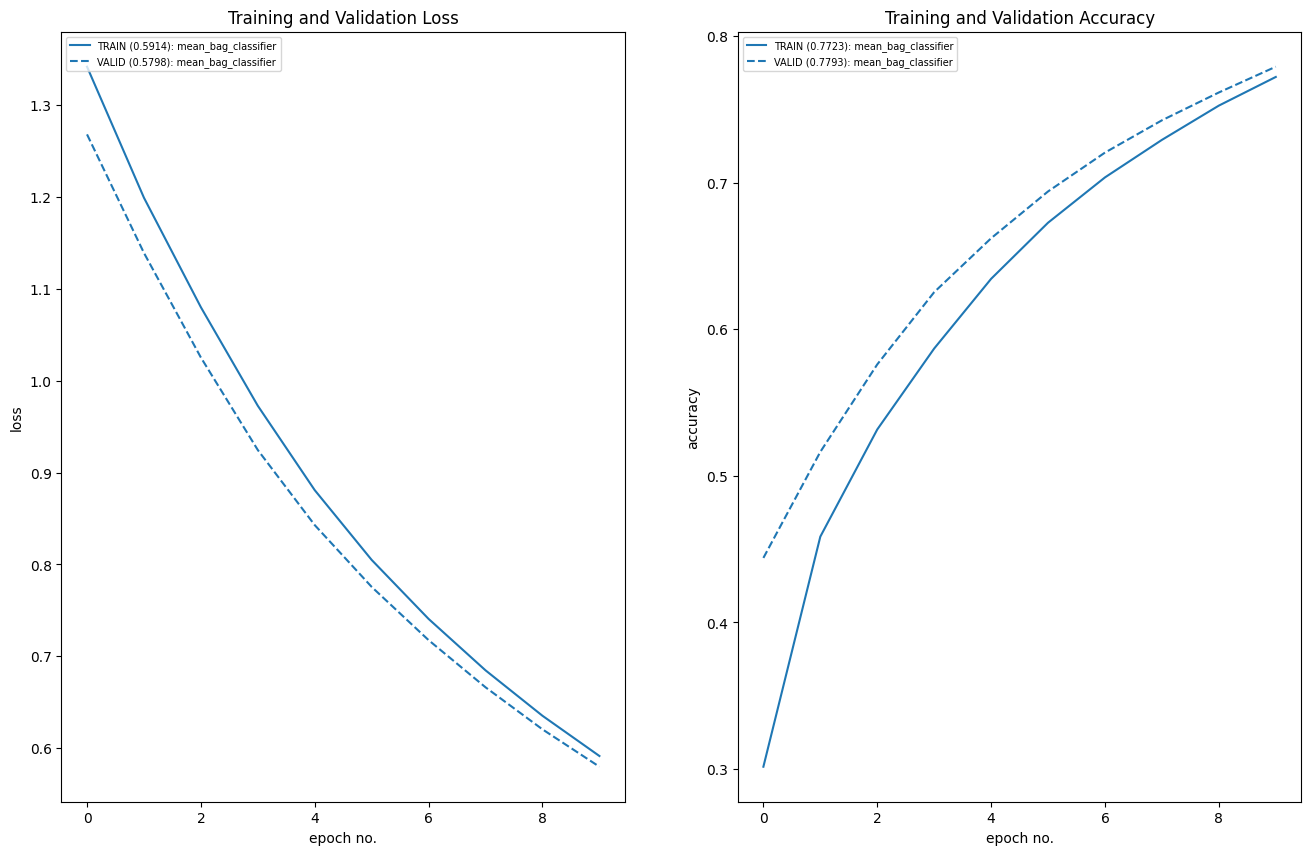

In [189]:
plot_loss_accuracy(train_loss= [train_losses],
                   val_loss= [test_losses],
                   train_acc= [train_metrics],
                   val_acc= [test_metrics],
                   labels=['mean_bag_classifier'],
                   colors=['blue'],
                   loss_legend_loc='upper left',
                   acc_legend_loc='upper left',
                   legend_font=7)

max/sum bag classifier:- Taking the max/sum of each sentence in the batch

In [194]:
bag_classifier = EmbeddingbagClassifier(num_classes=4, mode='sum')

In [195]:
# driver setup
optimizer = optim.Adam(bag_classifier.parameters(), lr=lr, weight_decay=1e-3)
criterion = nn.CrossEntropyLoss()
metric = MulticlassAccuracy(device = device, num_classes=10)

In [196]:
# Place holders----
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(0,epochs):
  print(f'Epoch {epoch}')
  train_losses, train_metrics = train_module(bag_classifier, device, train_loader, optimizer, criterion, metric, train_losses, train_metrics)
  test_losses , test_metrics = test_module(bag_classifier, device, test_loader, criterion, metric, test_losses, test_metrics)

Epoch 0


Avg Train Loss: 1.2518962106462252 Avg Train Metric: 0.3823640667280908: 100%|██████████| 118/118 [00:07<00:00, 14.82it/s]
Avg Test Loss: 1.1379971355199814 Avg Test Metric: 0.5083362832665443: 100%|██████████| 8/8 [00:00<00:00, 23.37it/s]


Epoch 1


Avg Train Loss: 1.0988853129289917 Avg Train Metric: 0.516191187298904: 100%|██████████| 118/118 [00:07<00:00, 15.62it/s]
Avg Test Loss: 1.0350858122110367 Avg Test Metric: 0.572837196290493: 100%|██████████| 8/8 [00:00<00:00, 23.85it/s]


Epoch 2


Avg Train Loss: 1.0022163007218958 Avg Train Metric: 0.5695726669440835: 100%|██████████| 118/118 [00:07<00:00, 15.35it/s]
Avg Test Loss: 0.9457027465105057 Avg Test Metric: 0.6099237874150276: 100%|██████████| 8/8 [00:00<00:00, 23.35it/s]


Epoch 3


Avg Train Loss: 0.9158498806468511 Avg Train Metric: 0.6132423443309332: 100%|██████████| 118/118 [00:08<00:00, 14.72it/s]
Avg Test Loss: 0.8670414239168167 Avg Test Metric: 0.6524943560361862: 100%|██████████| 8/8 [00:00<00:00, 23.88it/s]


Epoch 4


Avg Train Loss: 0.8379479939654723 Avg Train Metric: 0.6518135575924889: 100%|██████████| 118/118 [00:07<00:00, 16.16it/s]
Avg Test Loss: 0.797439806163311 Avg Test Metric: 0.6874101758003235: 100%|██████████| 8/8 [00:00<00:00, 23.22it/s]


Epoch 5


Avg Train Loss: 0.7702280591099949 Avg Train Metric: 0.6836317201792184: 100%|██████████| 118/118 [00:07<00:00, 15.70it/s]
Avg Test Loss: 0.738485686480999 Avg Test Metric: 0.7117755562067032: 100%|██████████| 8/8 [00:00<00:00, 23.63it/s]


Epoch 6


Avg Train Loss: 0.710698318683495 Avg Train Metric: 0.7110897504677207: 100%|██████████| 118/118 [00:07<00:00, 15.12it/s]
Avg Test Loss: 0.6880236864089966 Avg Test Metric: 0.7316854596138: 100%|██████████| 8/8 [00:00<00:00, 23.36it/s]


Epoch 7


Avg Train Loss: 0.658214606976105 Avg Train Metric: 0.733954519033432: 100%|██████████| 118/118 [00:07<00:00, 15.31it/s]
Avg Test Loss: 0.6462731435894966 Avg Test Metric: 0.7450085654854774: 100%|██████████| 8/8 [00:00<00:00, 23.74it/s]


Epoch 8


Avg Train Loss: 0.6121781885118808 Avg Train Metric: 0.7534621453891366: 100%|██████████| 118/118 [00:07<00:00, 15.92it/s]
Avg Test Loss: 0.6066856160759926 Avg Test Metric: 0.7602094262838364: 100%|██████████| 8/8 [00:00<00:00, 22.73it/s]


Epoch 9


Avg Train Loss: 0.5717062109102637 Avg Train Metric: 0.769621934931157: 100%|██████████| 118/118 [00:07<00:00, 15.74it/s]
Avg Test Loss: 0.5672625303268433 Avg Test Metric: 0.7782190442085266: 100%|██████████| 8/8 [00:00<00:00, 23.12it/s]


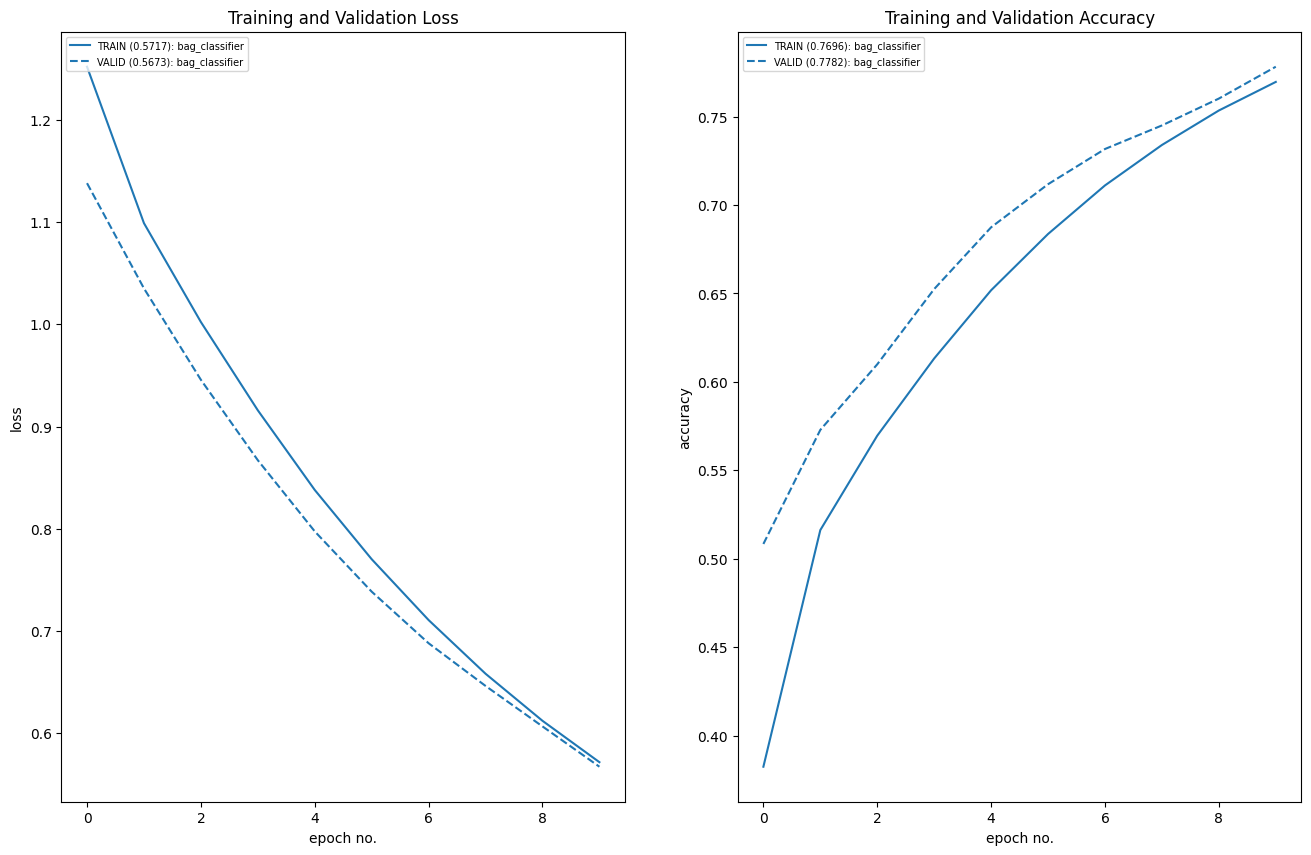

In [197]:
plot_loss_accuracy(train_loss= [train_losses],
                   val_loss= [test_losses],
                   train_acc= [train_metrics],
                   val_acc= [test_metrics],
                   labels=['bag_classifier'],
                   colors=['blue'],
                   loss_legend_loc='upper left',
                   acc_legend_loc='upper left',
                   legend_font=7)

In [198]:
Y_actual, Y_preds = MakePredictions(bag_classifier, test_loader)

In [199]:
print("Test Accuracy : {}".format(accuracy_score(Y_actual, Y_preds)))
print("\nClassification Report : ")
print(classification_report(Y_actual, Y_preds, target_names=target_classes))
print("\nConfusion Matrix : ")
print(confusion_matrix(Y_actual, Y_preds))

Test Accuracy : 0.7853947368421053

Classification Report : 
              precision    recall  f1-score   support

       World       0.81      0.78      0.80      1900
      Sports       0.80      0.91      0.85      1900
    Business       0.77      0.73      0.75      1900
    Sci/Tech       0.77      0.72      0.74      1900

    accuracy                           0.79      7600
   macro avg       0.78      0.79      0.78      7600
weighted avg       0.78      0.79      0.78      7600


Confusion Matrix : 
[[1489  178  135   98]
 [  72 1729   46   53]
 [ 141  111 1379  269]
 [ 141  149  238 1372]]


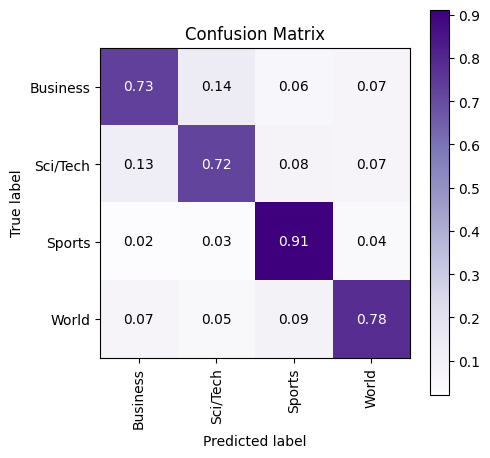

In [200]:
skplt.metrics.plot_confusion_matrix([target_classes[i] for i in Y_actual], [target_classes[i] for i in Y_preds],
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Purples",
                                    hide_zeros=True,
                                    figsize=(5,5)
                                    );
plt.xticks(rotation=90);

#### References:
1. https://coderzcolumn.com/tutorials/artificial-intelligence/word-embeddings-for-pytorch-text-classification-networks
2. https://jamesmccaffrey.wordpress.com/2021/04/14/explaining-the-pytorch-embeddingbag-layer/
3. https://www.kaggle.com/code/pinkaxe/pytorch-with-embeddingbag-layer
4. https://www.kaggle.com/code/alexandervc/op2-pytorch-embeddings-for-beginners

#### Next Readups:
1. https://pytorch.org/tutorials/beginner/text_sentiment_ngrams_tutorial.html
2. https://medium.com/@parkermo_86729/using-pytorch-hugging-face-and-a-pretrained-bert-model-to-create-news-source-classifier-a-46dddbd4d919
3. https://towardsdatascience.com/deep-learning-for-nlp-with-pytorch-and-torchtext-4f92d69052f
4. https://github.com/mjc92/TorchTextTutorial/blob/master/01.%20Getting%20started.ipynb
5. https://anie.me/On-Torchtext/